In [1]:
import pandas as pd
import json
import networkx as nx
import ast
import community

def load_network_from_json(file_path):
    with open(file_path, 'r') as f:
        data = json.load(f)
        G = nx.node_link_graph(data)
    return G

file_path = 'data/network_with_attributes.json'
G = load_network_from_json(file_path)


network_df = pd.read_csv('data/df_clean_data_with_comm.csv', sep=';', names = ['prod_id','prod','pris/stk','link','catagory','pris','mængde','overkatagori','naboer','description','d_length','ecology','Pairs','community','degree'])

***The closness centrality***

In [2]:
centrality_of_G = nx.closeness_centrality(G)

In [58]:

sorted_closeness = sorted(centrality_of_G.items(), key=lambda item: item[1], reverse=True)
top15_closeness = sorted_closeness[:15]
# for p_id, value in sorted_closeness[:15]:
#     top15_closeness.append()
# top15_closeness[0]['naboer']

In [54]:
test = top15_closeness[0]['naboer'].apply(ast.literal_eval).tolist()[0]
len(test)

10

In [59]:
top15_closeness

[(18364, 0.34026372706342006),
 (29439, 0.33631003689273525),
 (61090, 0.32341921151231806),
 (39411, 0.32219065865098767),
 (53366, 0.3211087700816434),
 (19721, 0.3191336212537626),
 (82376, 0.3181551307978342),
 (119482, 0.31776127182694813),
 (72008, 0.3175957280541808),
 (53365, 0.3173683868028893),
 (40165, 0.3154490475728469),
 (51061, 0.3145335526103641),
 (18381, 0.31242793081358106),
 (41860, 0.3096606241467983),
 (39353, 0.3087588237156152)]

In [62]:
import ast
bridge_dict_closeness = dict()
for (node, val) in top15_closeness:
    bridge_dict_closeness[str(node)] = set()
    for (self, neighbour_node) in G.edges(node):
        bridge_dict_closeness[str(self)].add(G._node[neighbour_node]['community'])
            
            #bridge_dict_closeness[str(node['prod'].tolist()[0])].add(network_df[network_df["prod_id"]==nabo]['community'].tolist()[0])
bridge_dict_closeness

{'18364': {0, 2, 3, 4, 5, 6, 16, 18, 21, 23},
 '29439': {0, 2, 3, 4, 5, 6, 8, 9, 18, 21, 24},
 '61090': {0, 2, 3, 4, 6, 12, 18, 23},
 '39411': {0, 2, 3, 4},
 '53366': {0, 2, 3, 18, 23},
 '19721': {0, 1, 4, 5, 6, 7, 16, 24},
 '82376': {0, 2, 4, 5, 8, 9},
 '119482': {0, 2, 8},
 '72008': {0, 2, 3, 6, 12, 13, 19},
 '53365': {0, 1, 2, 5, 8, 13, 18},
 '40165': {0, 2, 9},
 '51061': {0, 2, 6, 8, 16},
 '18381': {0, 2, 3, 4, 6, 12, 13},
 '41860': {0, 1, 2, 3, 4, 12, 22, 24},
 '39353': {0, 1, 2, 3, 9, 17, 22}}

***Betweenness centrality***
Betweenness is a centrality measure of a vertex within a graph (there is also edge betweenness, which is not discussed here). Betweenness centrality quantifies the number of times a node acts as a bridge along the shortest path between two other nodes. [https://en.wikipedia.org/wiki/Centrality]

In [5]:
#calculate the betweenness centrality of the entire graph. 
betweenness_of_G = nx.betweenness_centrality(G)

In [64]:
sorted_betweenness = sorted(betweenness_of_G.items(), key=lambda item: item[1], reverse=True)
top15 = sorted_betweenness[:15]
top15

[(18364, 0.029281001959232392),
 (29439, 0.021855598066004425),
 (19721, 0.007246604658721503),
 (39353, 0.006221691778238507),
 (61090, 0.006172700660317658),
 (53366, 0.005927257490907317),
 (39411, 0.005753901560903707),
 (53365, 0.005466864612346025),
 (41860, 0.005017276796866279),
 (82376, 0.00488409846148874),
 (18381, 0.004677436261855312),
 (119482, 0.0045251982613894555),
 (72008, 0.004478263697298725),
 (51061, 0.0042960374872220665),
 (71507, 0.004068930069322418)]

In [65]:
import ast
bridge_dict = dict()
for (node, val) in top15_closeness:
    bridge_dict[str(node)] = set()
    for (self, neighbour_node) in G.edges(node):
        bridge_dict[str(self)].add(G._node[neighbour_node]['community'])
            
            #bridge_dict[str(node['prod'].tolist()[0])].add(network_df[network_df["prod_id"]==nabo]['community'].tolist()[0])
         
            #print(network_df[network_df["prod_id"]==nabo]['community'])
bridge_dict
            

{'18364': {0, 2, 3, 4, 5, 6, 16, 18, 21, 23},
 '29439': {0, 2, 3, 4, 5, 6, 8, 9, 18, 21, 24},
 '61090': {0, 2, 3, 4, 6, 12, 18, 23},
 '39411': {0, 2, 3, 4},
 '53366': {0, 2, 3, 18, 23},
 '19721': {0, 1, 4, 5, 6, 7, 16, 24},
 '82376': {0, 2, 4, 5, 8, 9},
 '119482': {0, 2, 8},
 '72008': {0, 2, 3, 6, 12, 13, 19},
 '53365': {0, 1, 2, 5, 8, 13, 18},
 '40165': {0, 2, 9},
 '51061': {0, 2, 6, 8, 16},
 '18381': {0, 2, 3, 4, 6, 12, 13},
 '41860': {0, 1, 2, 3, 4, 12, 22, 24},
 '39353': {0, 1, 2, 3, 9, 17, 22}}

In [69]:
bridge_dict_closeness
#network_df[network_df["prod_id"]==nabo]['community']


{'18364': {0, 2, 3, 4, 5, 6, 16, 18, 21, 23},
 '29439': {0, 2, 3, 4, 5, 6, 8, 9, 18, 21, 24},
 '61090': {0, 2, 3, 4, 6, 12, 18, 23},
 '39411': {0, 2, 3, 4},
 '53366': {0, 2, 3, 18, 23},
 '19721': {0, 1, 4, 5, 6, 7, 16, 24},
 '82376': {0, 2, 4, 5, 8, 9},
 '119482': {0, 2, 8},
 '72008': {0, 2, 3, 6, 12, 13, 19},
 '53365': {0, 1, 2, 5, 8, 13, 18},
 '40165': {0, 2, 9},
 '51061': {0, 2, 6, 8, 16},
 '18381': {0, 2, 3, 4, 6, 12, 13},
 '41860': {0, 1, 2, 3, 4, 12, 22, 24},
 '39353': {0, 1, 2, 3, 9, 17, 22}}

We examine which categories is in a given community, partly to make sure the communities isn't simply the default categories from the salling website. We do this by making a set of all the different categories the nodes in the given community contains. 

In [110]:
catagories_in_community = set()
node_dict = nx.get_node_attributes(G,'community')
community_categories = dict()
for com in range(25):
    community_categories[com] = {G._node[node]['category'] for node, community in node_dict.items() if community==15}

Make a subgraph based on communities

In [169]:
bridge_dict


{'18364': {0, 2, 3, 4, 5, 6, 16, 18, 21, 23},
 '29439': {0, 2, 3, 4, 5, 6, 8, 9, 18, 21, 24},
 '61090': {0, 2, 3, 4, 6, 12, 18, 23},
 '39411': {0, 2, 3, 4},
 '53366': {0, 2, 3, 18, 23},
 '19721': {0, 1, 4, 5, 6, 7, 16, 24},
 '82376': {0, 2, 4, 5, 8, 9},
 '119482': {0, 2, 8},
 '72008': {0, 2, 3, 6, 12, 13, 19},
 '53365': {0, 1, 2, 5, 8, 13, 18},
 '40165': {0, 2, 9},
 '51061': {0, 2, 6, 8, 16},
 '18381': {0, 2, 3, 4, 6, 12, 13},
 '41860': {0, 1, 2, 3, 4, 12, 22, 24},
 '39353': {0, 1, 2, 3, 9, 17, 22}}

In [168]:
def get_subgraph(community_list):
    '''
    input: A list or set of communities to filter for.

    output: A networkx subgraph containing only the nodes in the given communities.
    '''
    nodes = (node for node, data in G.nodes(data=True) if data.get("community") in community_list and G.degree(node)>=1)
    return G.subgraph(nodes)
subgraph = get_subgraph(bridge_dict['18364'])
#subgraph = get_subgraph([0,5])
len(subgraph)

6290

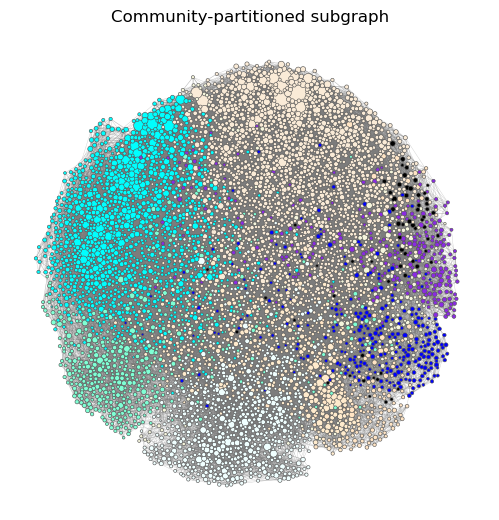

In [182]:
def vis_graph(graph, title='Community-partitioned subgraph'):
    import matplotlib.colors as mcolors
    from netwulf import visualize, draw_netwulf

    colors = list(mcolors.CSS4_COLORS.keys())
    n_colors = len(colors) 

    sorted_communities = dict(sorted(nx.get_node_attributes(subgraph,'community').items(),key=lambda x: x[1],reverse=True))
    community_colors = {community: colors[i % n_colors+1] for i, community in enumerate(set(sorted_communities.values()))}

    for idx, (node, commun) in enumerate(sorted_communities.items()):
        graph.nodes[node]['color'] = community_colors[commun]

    network, _ = visualize(graph)
    fig, ax = draw_netwulf(network)
    ax.set_title(title)
vis_graph(subgraph)

In [180]:
sorted_communities = sorted(nx.get_node_attributes(subgraph,'community').items(),key=lambda x: x[1],reverse=True)
sorted_communities

[(57280, 23),
 (63876, 23),
 (93855, 23),
 (48980, 23),
 (33276, 23),
 (94196, 23),
 (93863, 23),
 (93859, 23),
 (87818, 23),
 (63919, 23),
 (63873, 23),
 (16681, 23),
 (16680, 23),
 (93838, 23),
 (54205, 23),
 (93845, 23),
 (93856, 23),
 (93854, 23),
 (93853, 23),
 (93851, 23),
 (93849, 23),
 (93848, 23),
 (93844, 23),
 (93842, 23),
 (93862, 23),
 (93864, 23),
 (93847, 23),
 (93846, 23),
 (72555, 23),
 (93843, 23),
 (93857, 23),
 (93860, 23),
 (63862, 23),
 (63859, 23),
 (16679, 23),
 (63863, 23),
 (83354, 23),
 (110902, 23),
 (48979, 23),
 (93861, 23),
 (79948, 23),
 (42479, 23),
 (93852, 23),
 (72556, 23),
 (63938, 23),
 (93850, 23),
 (63908, 23),
 (54221, 23),
 (93858, 23),
 (54235, 23),
 (107066, 23),
 (64460, 23),
 (85041, 23),
 (123697, 23),
 (63901, 23),
 (106671, 23),
 (90251, 23),
 (57551, 23),
 (57279, 23),
 (57278, 23),
 (57012, 23),
 (48514, 23),
 (54392, 23),
 (16708, 23),
 (72553, 23),
 (59487, 23),
 (63864, 23),
 (63861, 23),
 (54222, 23),
 (106148, 23),
 (70096, 23),
 